<div align="center" style="width: 100%; background-color: #F7F7F7; margin-bottom: 3em;">
    <h1 style="font-family: courier; font-size: 4em; padding-top: .5em;"><b>Brazilian Lottery</b></h1>
    <img src="../img/brazilian-lottery.png">    
</div>

### Mega Sena 

Este é um estudo sobre os dados públicos da mais famosa loteria brasileira, a **Mega Sena**. No sentido matemático e estatístico é uma boa investida, uma vez que temos informações importantes, tanto em relação a análise combinatória quanto a questão fiscal. Já viu a relação entre arrecadação e premiação? 

As loterias sempre vão ser lucrativas. No caso da mega sena temos sessenta dezenas que geram mais de **50 milhões** de possibilidades, para ser preciso, **50.063.860** combinações possíveis.

> Existe uma diferença entre improvável e impossível... 

Quando se trata de loteria, todas as combinações têm a mesma probabilidade. Esse é um assunto para o final deste notebook.

#### Dataset

Os dados utilizado neste estudo podem ser encontrados no [Portal de Loterias da Caixa Econômica Federal][portal1].

[portal1]: <http://loterias.caixa.gov.br/wps/portal/loterias/landing/megasena/>

In [3]:
import pandas as pd
import locale
import matplotlib
import matplotlib.pyplot as plt
import numpy as np 
from bs4 import BeautifulSoup
import seaborn as sns

sns.set(style="whitegrid")
pal = sns.dark_palette("palegreen", as_cmap=True)

%matplotlib inline

## Get data

Para construir o dataset foi utilizado o seguinte arquivo disponibilizado pela Caixa Ecônomica Federal: [D_mgsasc.zip][link_file]

Aqui não temos dados de simples processamento, como um csv, por exemplo. O arquivo em questão se trata de um **.html** com algumas particularidades, por isso precisamos carregar os dados e realizar o tratamento necessário.

Neste caso específico, vou ler o arquivo **html** usando `BeautifulSoup` para o parse e search das tags. O código abaixo faz parte da ingestão e tratamento de dados base para nossa análise.

[link_file]: <http://www1.caixa.gov.br/loterias/_arquivos/loterias/D_mgsasc.zip>

In [4]:
%%time

with open('../data/d_megasc.htm','rb') as f:
    contents = f.read()

soup = BeautifulSoup(contents,'html.parser')

CPU times: user 13.3 s, sys: 68.2 ms, total: 13.4 s
Wall time: 13.4 s


In [34]:
table = soup.find('table')
trs = table.find_all('tr')

first = trs[0]
allRows = trs[1:-1]

headers = [header.get_text() for header in first.find_all('th')]
results = [[data.get_text() for data in row.find_all('td')] for row in allRows]

print(f'Quantidade de colunas no cabeçalho: {len(headers)}')
print(f'Quantidade de linhas: {len(results)}')

Quantidade de colunas no cabeçalho: 21
Quantidade de linhas: 2392


In [35]:
rowspan = []

for no, tr in enumerate(allRows):
    tmp = []
    for td_no, data in enumerate(tr.find_all('td')):
        if data.has_attr("rowspan"):
            rowspan.append((no, td_no, int(data["rowspan"]), data.get_text()))

if rowspan:
    for i in rowspan:
        # tr value of rowspan in present in 1th place in results
        for j in range(1, i[2]):
            # add value in next tr.
            results[i[0]+j].insert(i[1], i[3])

In [36]:
print(headers)

['Concurso', 'Data Sorteio', '1ª Dezena', '2ª Dezena', '3ª Dezena', '4ª Dezena', '5ª Dezena', '6ª Dezena', 'Arrecadacao_Total', 'Ganhadores_Sena', 'Cidade', 'UF', 'Rateio_Sena', 'Ganhadores_Quina', 'Rateio_Quina', 'Ganhadores_Quadra', 'Rateio_Quadra', 'Acumulado', 'Valor_Acumulado', 'Estimativa_Prêmio', 'Acumulado_Mega_da_Virada']


In [37]:
df = pd.DataFrame(data=results, columns=headers)

print(len(df))

df.head(5)

2392


,Concurso,Data Sorteio,1ª Dezena,2ª Dezena,3ª Dezena,4ª Dezena,5ª Dezena,6ª Dezena,Arrecadacao_Total,Ganhadores_Sena,...,UF,Rateio_Sena,Ganhadores_Quina,Rateio_Quina,Ganhadores_Quadra,Rateio_Quadra,Acumulado,Valor_Acumulado,Estimativa_Prêmio,Acumulado_Mega_da_Virada
0,1,11/03/1996,04,05,30,33,41,52,"0,00",0,...,,"0,00",17,"39.158,92",2016,"330,21",SIM,"1.714.650,23","0,00","0,00"
1,2,18/03/1996,09,37,39,41,43,49,"0,00",1,...,PR\r,"2.307.162,23",65,"14.424,02",4488,"208,91",NÃO,"0,00","0,00","0,00"
2,3,25/03/1996,10,11,29,30,36,47,"0,00",2,...,RN\r,"391.192,51",62,"10.515,93",4261,"153,01",NÃO,"0,00","0,00","0,00"
3,3,25/03/1996,10,11,29,30,36,47,"0,00",2,...,SP\r,"391.192,51",62,"10.515,93",4261,"153,01",NÃO,"0,00","0,00","0,00"
4,4,01/04/1996,01,05,06,27,42,59,"0,00",0,...,,"0,00",39,"15.322,24",3311,"180,48",SIM,"717.080,75","0,00","0,00"


In [38]:
df = df.drop('Cidade',axis=1)
df = df.drop('UF',axis=1)

df = df.rename(columns={
    'Data Sorteio': 'Data', 
    '1ª Dezena': 'D1', 
    '2ª Dezena': 'D2', 
    '3ª Dezena': 'D3', 
    '4ª Dezena': 'D4', 
    '5ª Dezena': 'D5', 
    '6ª Dezena': 'D6'})

df['Arrecadacao_Total'] = df['Arrecadacao_Total'].apply(lambda Arrecadacao_Total: Arrecadacao_Total.replace('.', '').replace(',', '.'))
df['Rateio_Sena'] = df['Rateio_Sena'].apply(lambda Rateio_Sena: Rateio_Sena.replace('.', '').replace(',', '.'))
df['Rateio_Quina'] = df['Rateio_Quina'].apply(lambda Rateio_Quina: Rateio_Quina.replace('.', '').replace(',', '.'))
df['Rateio_Quadra'] = df['Rateio_Quadra'].apply(lambda Rateio_Quadra: Rateio_Quadra.replace('.', '').replace(',', '.'))

columns_to_float=["Arrecadacao_Total","Rateio_Sena","Rateio_Quina","Rateio_Quadra"]
df[columns_to_float] = df[columns_to_float].astype(float)

columns_to_int=["Ganhadores_Sena", "Ganhadores_Quina", "Ganhadores_Quadra"]
df[winners_head] = df[winners_head].apply(pd.to_numeric)

df["Data"] = pd.to_datetime(df["Data"])

df["D1"] = pd.to_numeric(df["D1"])
df["D2"] = pd.to_numeric(df["D2"])
df["D3"] = pd.to_numeric(df["D3"])
df["D4"] = pd.to_numeric(df["D4"])
df["D5"] = pd.to_numeric(df["D5"])
df["D6"] = pd.to_numeric(df["D6"])

mega_results = df.drop_duplicates(['Concurso'])

print(len(mega_results))
mega_results.head(5)

2124


,Concurso,Data,D1,D2,D3,D4,D5,D6,Arrecadacao_Total,Ganhadores_Sena,Rateio_Sena,Ganhadores_Quina,Rateio_Quina,Ganhadores_Quadra,Rateio_Quadra,Acumulado,Valor_Acumulado,Estimativa_Prêmio,Acumulado_Mega_da_Virada
0,1,1996-11-03,4,5,30,33,41,52,0.0,0,0.00,17,39158.92,2016,330.21,SIM,"1.714.650,23","0,00","0,00"
1,2,1996-03-18,9,37,39,41,43,49,0.0,1,2307162.23,65,14424.02,4488,208.91,NÃO,"0,00","0,00","0,00"
2,3,1996-03-25,10,11,29,30,36,47,0.0,2,391192.51,62,10515.93,4261,153.01,NÃO,"0,00","0,00","0,00"
4,4,1996-01-04,1,5,6,27,42,59,0.0,0,0.00,39,15322.24,3311,180.48,SIM,"717.080,75","0,00","0,00"
5,5,1996-08-04,1,2,6,16,19,46,0.0,0,0.00,98,5318.10,5399,96.53,SIM,"1.342.488,85","0,00","0,00"


In [23]:
mega_results.dtypes

Concurso                            object
Data                        datetime64[ns]
D1                                   int64
D2                                   int64
D3                                   int64
D4                                   int64
D5                                   int64
D6                                   int64
Arrecadacao_Total                  float64
Ganhadores_Sena                      int64
Rateio_Sena                        float64
Ganhadores_Quina                     int64
Rateio_Quina                       float64
Ganhadores_Quadra                    int64
Rateio_Quadra                      float64
Acumulado                           object
Valor_Acumulado                     object
Estimativa_Prêmio                   object
Acumulado_Mega_da_Virada            object
dtype: object

O novo cabeçalho indica as colunas disponíveis para nosso trabalho:

* Data;
* D1;
* D2; 
* D3; 
* D4; 
* D5; 
* D6; 
* Arrecadacao_Total; 
* Sena; 
* Rateio_Sena; 
* Quina; 
* Rateio_Quina; 
* Quadra; 
* Rateio_Quadra; 
* Acumulado; 
* Valor_Acumulado   

Vamos começar calculando quantas vezes cada uma das dezenas já foi sorteada na megasena. Para isso, criaremos um subconjunto contendo as colunas referentes as dezenas sorteadas. 

Depois disso, achataremos essas colunas em um único vetor e utilizaremos o método **value_counts** de uma série de valores. Logo em seguida, converteremos o resultado desse calculo em um DataFrame.

Utilizaremos a biblioteca *Seaborn* para plotar o nosso gráfico de barras. No eixo Y iremos apresentar o número da dezena e no eixo X a quantidade de vezes que essa bolinha foi sorteada em algum concurso da Mega.



/Users/vitormeriat/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


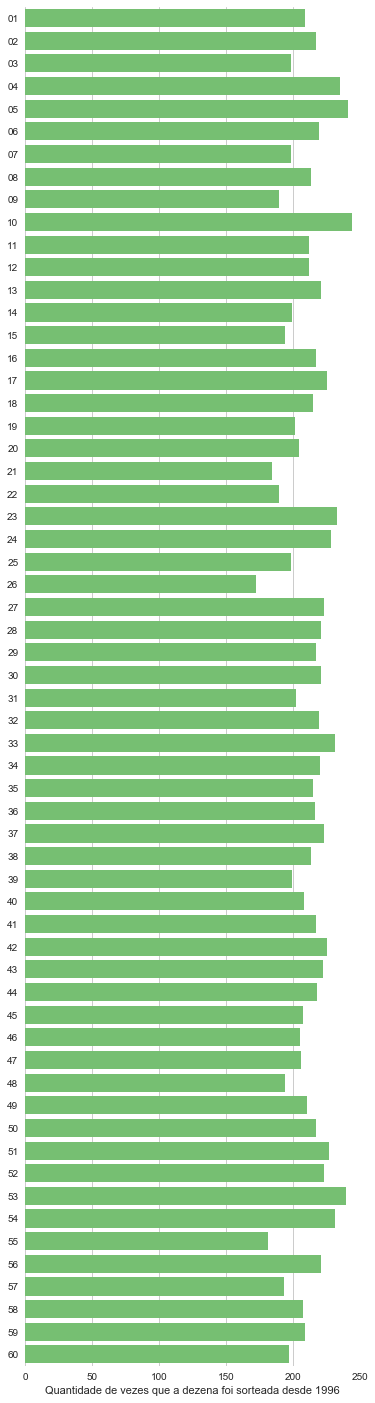

In [37]:
balls = mega_results[['D1','D2','D3','D4','D5','D6']]
balls_agg = pd.DataFrame( balls.values.flatten(), columns=['total'] )

balls_count = balls_agg['total'].value_counts(sort=True).to_frame().reset_index()

f, ax = plt.subplots(figsize=(6, 25))

sns.barplot(y="index", x="total", data=balls_count, label="Total", orient='h', color='g')


ax.set(xlim=(0, 250), ylabel="", xlabel="Quantidade de vezes que a dezena foi sorteada desde 1996")
sns.despine(left=True, bottom=True)

A contagem de quantas vezes cada dezena foi sorteada nos permite facilmente identificar que as dezenas 22, 26, 55, 21 e 25 são as dezenas menos sorteadas, enquanto as dezenas 5, 51, 53, 42 e 4 são as que sairam mais vezes.

Vamos calcular agora a quantidade de vezes que duas dezenas foram escolhidas no mesmo sorteio. Para isso utilizaremos a função *combinations* do módulo itertools da biblioteca padrão do Python e um *defaultdict* do módulo collections. 

Iremos iterar sobre o nosso subconjunto de resultados (que possui as colunas D1 .. D6 ), tomando os valores de dois a dois e incrementando no dicionário a contagem de vezes que a dupla aparece. PS. Como estamos utilizando combinations e nossos resultados estão ordenados, não é preciso se preocupar com chaves em posições diferentes, visto que nunca existirá a combinação (2,1) se existir a (1,2).

Depois da iteração, transformaremos nosso dicionário em um DataFrame com duas colunas (dezenas e total de vezes que aparece junto), para logo em seguida separar a coluna dezenas em D1 e D2 para facilitar o trabalho com os dados.

In [38]:
from itertools import combinations
from collections import defaultdict
pair_list = defaultdict(lambda: 0, [])
    
for values in balls.iterrows():
    for k in combinations(values[1], 2):
        pair_list[k] += 1
        #pair_list[k[::-1]] += 1
    
pairs = pd.DataFrame( list(pair_list.items()), columns=['dezenas', 'total'] )

new_col_list = ['d1','d2']
for n,col in enumerate(new_col_list):
    pairs[col] = pairs['dezenas'].apply(lambda dezena: dezena[n])

Uma maneira interessante de observar as combinações entre duas dezenas sorteadas e a frequência com que essas dezenas são sorteadas juntas é utilizando um *heatmap*. Vamos utilizar o *Seaborn* para fazer isso. Quanto mais escuro no gráfico a combinação entre a dezena X e a dezena Y, maior o número de vezes que elas foram sorteadas junto.

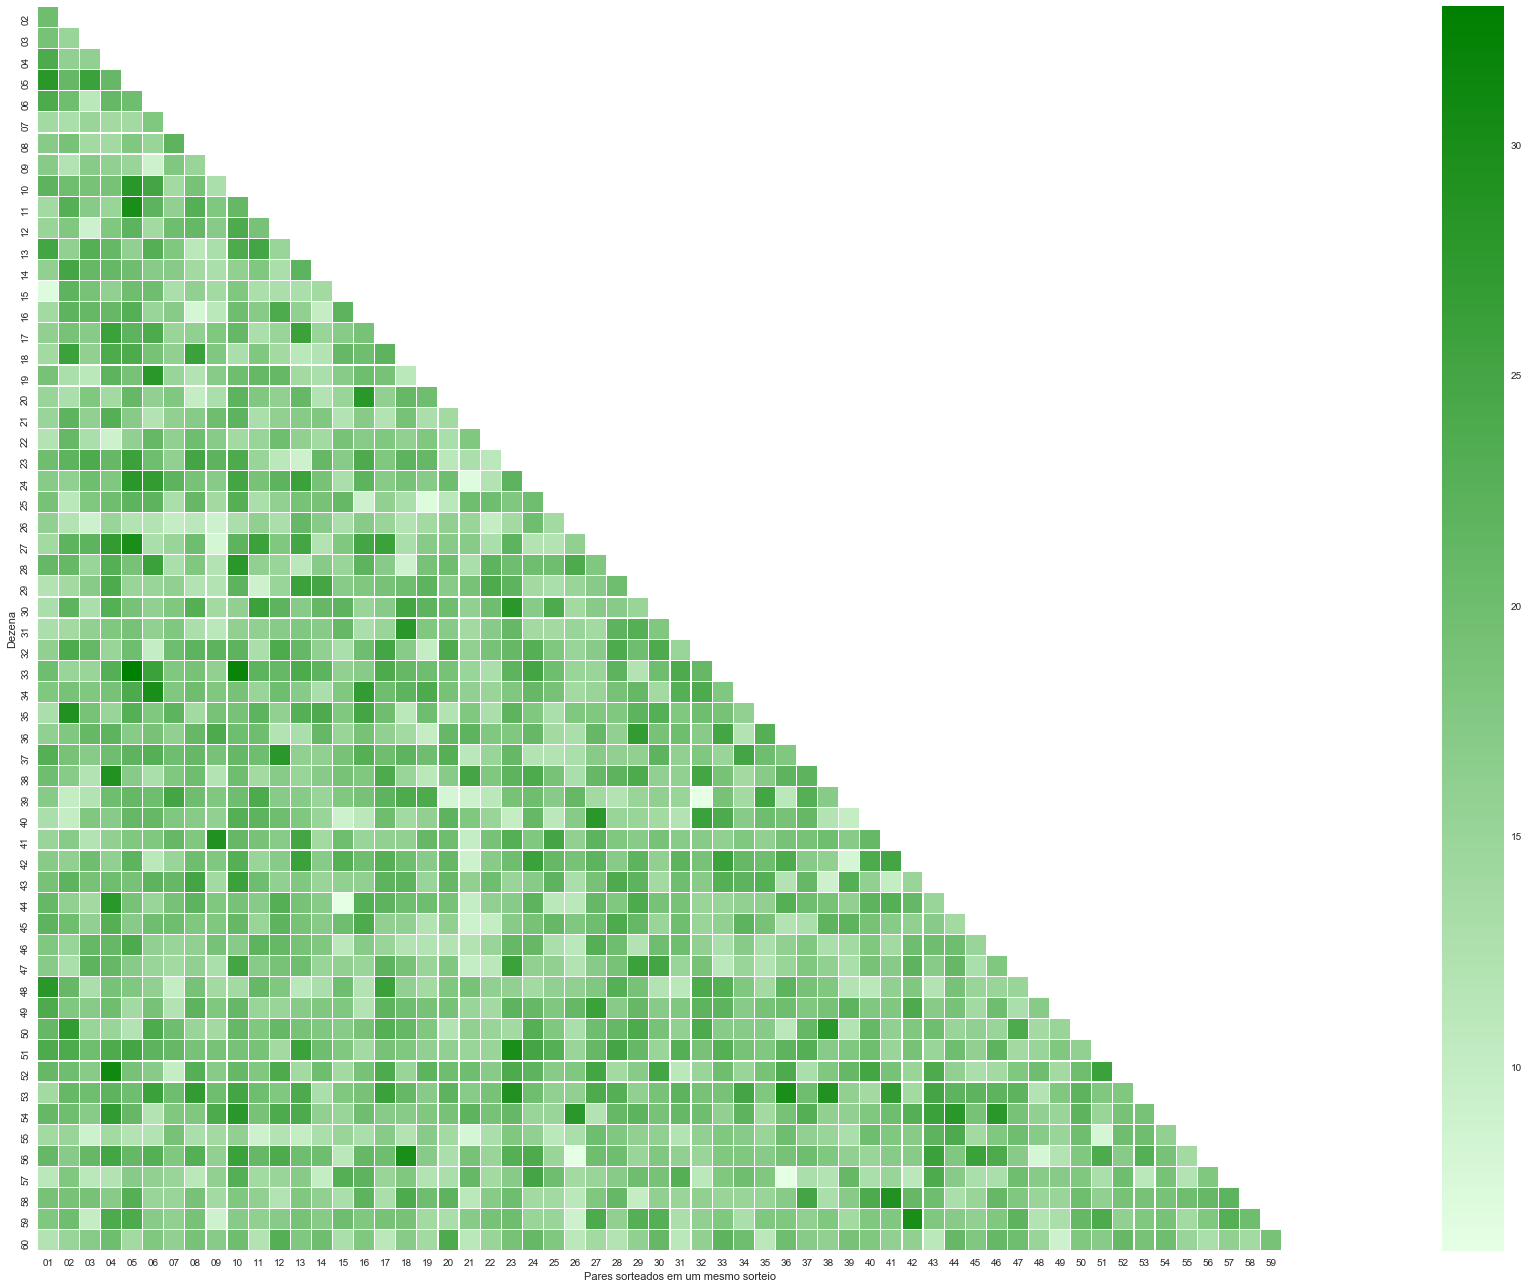

In [39]:
f, ax = plt.subplots(figsize=(33, 18))
pairs2 = pairs.pivot('d2','d1', 'total')
#pairs2.fillna(-1, inplace=True)
sns.color_palette("Paired")
sns.heatmap(pairs2, square=True, ax=ax, linewidths=.2, cmap=sns.light_palette("green", as_cmap=True))
ax.set(xlim=(0, 61), ylabel="Dezena", xlabel="Pares sorteados em um mesmo sorteio")
f.tight_layout()

As 20 combinações mais frequentes, agora no formato de lista:

In [40]:
pairs[['d1','d2','total']].sort_values('total', ascending=False)[:20]

,d1,d2,total
6,05,33,33
1311,10,33,32
4,04,52,31
863,23,51,30
898,06,34,30
51,05,27,30
178,18,56,30
290,36,53,30
921,05,11,30
59,42,59,30


Se desejarmos fazer a mesma coisa com trios de bolinhas sorteadas, a única coisa que devemos alterar é o agrupamento das combinações. Dessa vez, serão tomadas de 3 em 3.

In [133]:
terno_list = defaultdict(lambda: 0, [])
    
for values in balls.iterrows():
    for k in combinations(values[1], 3):
        terno_list[k] += 1

terno = pd.DataFrame( list(terno_list.items()), columns=['dezenas', 'total'] )

new_col_list = ['d1','d2','d3']
for n,col in enumerate(new_col_list):
    terno[col] = terno['dezenas'].apply(lambda dezena: dezena[n])

Os 50 trios de dezenas que mais foram sorteados juntos até hoje:

In [134]:
terno[['d1','d2', 'd3', 'total']].sort_values('total', ascending=False)[:50]

,d1,d2,d3,total
591,29,38,50,8
11301,21,30,52,7
864,29,44,47,7
9344,04,30,59,7
5889,29,32,38,7
999,24,25,42,7
622,14,33,36,7
6029,02,18,30,7
191,18,21,38,7
1193,06,13,24,6


In [137]:
quadra_list = defaultdict(lambda: 0, [])
    
for values in balls.iterrows():
    for k in combinations(values[1], 6):
        quadra_list[k] += 1

quadra = pd.DataFrame( list(quadra_list.items()), columns=['dezenas', 'total'] )

new_col_list = ['d1','d2','d3','d4']
for n,col in enumerate(new_col_list):
    quadra[col] = quadra['dezenas'].apply(lambda dezena: dezena[n])

In [138]:
quadra[['d1','d2', 'd3', 'd4', 'total']].sort_values('total', ascending=False)[:50]

,d1,d2,d3,d4,total
0,04,05,30,33,1
1411,06,08,24,37,1
1425,06,15,18,24,1
1424,07,16,29,36,1
1423,03,07,15,29,1
1422,03,08,21,25,1
1421,02,05,13,17,1
1420,19,31,39,44,1
1419,02,11,16,18,1
1418,17,21,30,48,1


In [139]:
quina_list = defaultdict(lambda: 0, [])
    
for values in balls.iterrows():
    for k in combinations(values[1], 6):
        quina_list[k] += 1

quina = pd.DataFrame( list(quina_list.items()), columns=['dezenas', 'total'] )

new_col_list = ['d1','d2','d3','d4','d5']
for n,col in enumerate(new_col_list):
    quina[col] = quina['dezenas'].apply(lambda dezena: dezena[n])

In [140]:
quina[['d1','d2', 'd3', 'd4', 'd5', 'total']].sort_values('total', ascending=False)[:50]

,d1,d2,d3,d4,d5,total
0,04,05,30,33,41,1
1411,06,08,24,37,41,1
1425,06,15,18,24,30,1
1424,07,16,29,36,38,1
1423,03,07,15,29,38,1
1422,03,08,21,25,27,1
1421,02,05,13,17,39,1
1420,19,31,39,44,53,1
1419,02,11,16,18,36,1
1418,17,21,30,48,52,1


In [141]:
sena_list = defaultdict(lambda: 0, [])
    
for values in balls.iterrows():
    for k in combinations(values[1], 6):
        sena_list[k] += 1


sena = pd.DataFrame( list(sena_list.items()), columns=['dezenas', 'total'] )

new_col_list = ['d1','d2','d3','d4','d5','d6']
for n,col in enumerate(new_col_list):
    sena[col] = sena['dezenas'].apply(lambda dezena: dezena[n])

In [142]:
sena[['d1','d2', 'd3', 'd4', 'd5', 'd6', 'total']].sort_values('total', ascending=False)[:50]

,d1,d2,d3,d4,d5,d6,total
0,04,05,30,33,41,52,1
1411,06,08,24,37,41,45,1
1425,06,15,18,24,30,44,1
1424,07,16,29,36,38,50,1
1423,03,07,15,29,38,60,1
1422,03,08,21,25,27,43,1
1421,02,05,13,17,39,44,1
1420,19,31,39,44,53,59,1
1419,02,11,16,18,36,45,1
1418,17,21,30,48,52,58,1


Agora você deve estar se perguntando por quê eu fiz tudo isso? Simples. Nunca antes na história da Mega-sena ela pagou tanto quanto tem pago nos últimos anos. Em Dezembro de 2015, só em prêmios foram pagos quase R$620.000.000 (Seiscentos e vinte milhões de Reais).

Como eu sei isso? Para calcular o total de prêmios, precisamos somar o número de acertadores da Sena com o valor da Sena, o número de acertadores da Quina com o valor da Quina e o número de acertadores da Quadra com o valor do prêmio da Quadra em cada concurso. Para fazer isso, vamos criar uma coluna chamada Premios e realizar essas operações.

Mas não são só os prêmios que são altos na Mega. O valor arrecadado também é gigantesco e aumente a cada ano.

Em seguida vamos utilizar a Data dos sorteios e agrupar ela por mês. Para deixar nosso gráfico bonito, vamos escolher apenas os concursos dos quais nós temos os dados da arrecadação.

Primeiro vamos plotar o gráfico das arrecadações, em uma cor mais fraca, e depois vamos plotar o gráfico da premiação, em uma cor mais forte.


/Users/vitormeriat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/vitormeriat/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[<matplotlib.text.Text at 0x126578400>, <matplotlib.text.Text at 0x110fc9e10>]

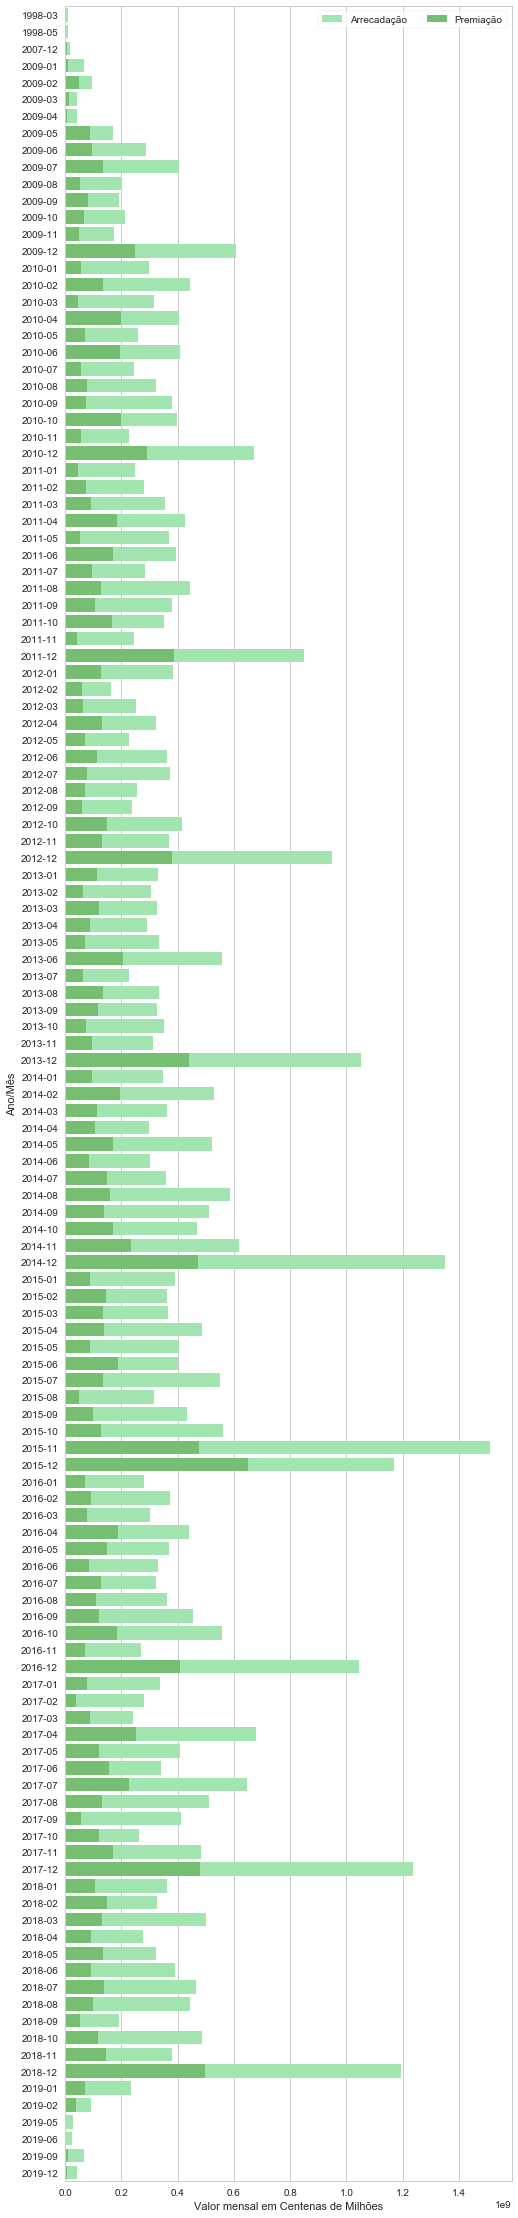

In [130]:
mega_results['Premios'] = mega_results['Ganhadores_Sena'] * mega_results['Rateio_Sena'] + mega_results['Ganhadores_Quina'] * mega_results['Rateio_Quina'] + mega_results['Ganhadores_Quadra'] * mega_results['Rateio_Quadra']

anos = mega_results[mega_results["Arrecadacao_Total"] > 0].groupby( mega_results.Data.dt.to_period('M'))
#anos = mega_results.groupby(mega_results.Data.dt.to_period('M'))

f, ax = plt.subplots(figsize=(8, 40))

sns.set_color_codes("pastel")
sns.barplot(y='Data', x='Arrecadacao_Total', label=u"Arrecadação", data=anos['Arrecadacao_Total'].sum().reset_index(), color='g', orient='h' )

sns.set_color_codes("muted")
sns.barplot(y='Data', x='Premios', label=u"Premiação", data=anos['Premios'].sum().reset_index(), color='g', orient='h' )

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylabel=u"Ano/Mês", xlabel=u"Valor mensal em Centenas de Milhões")

Só nos dois últimos meses de 2015, a Mega arrecadou quase RS2.9 bilhões. E deu pouco mais de RS1.1 bilhão em prêmios.